Let's now look at the problem of membrane deformation!

In [1]:
import gmsh
gmsh.initialize()

Now let's create the membrane of unit radius (centered at the origin).

In [2]:
membrane=gmsh.model.occ.addDisk(0,0,0,1,1) #0,0,0 sono le coordinate del centro ; 1,1 sono i raggi Rx ed Ry??
gmsh.model.occ.synchronize()

In [3]:
# let's make membrane a physical surface 
gdim=2 # we are talking about a 2D mesh
gmsh.model.addPhysicalGroup(gdim,[membrane],1)

1

In [4]:
# now I finally define the 2D mesh 
gmsh.option.setNumber("Mesh.CharacteristicLengthMin", 0.05)
gmsh.option.setNumber("Mesh.CharacteristicLengthMax", 0.05)
# in this way I made sure to have a uniform mesh!!!
gmsh.model.mesh.generate(gdim)

Info    : Meshing 1D...
Info    : Meshing curve 1 (Ellipse)
Info    : Done meshing 1D (Wall 0.00017975s, CPU 0.0002s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0444675s, CPU 0.043121s)
Info    : 1550 nodes 3099 elements


Now I need to create an interface between GMSH and DOLFINx.

In [5]:
from dolfinx.io import gmshio

from mpi4py import MPI

gmsh_model_rank = 0
mesh_comm = MPI.COMM_WORLD #MPI.COMM_WORLD è dov'é presente il modello della membrana appena creata
domain, cell_markers, facet_markers = gmshio.model_to_mesh(gmsh.model, mesh_comm, gmsh_model_rank, gdim=gdim)

Now that the domain is defined, I can define the vector space V of trial and test functions.

In [6]:
from dolfinx import fem 
V=fem.functionspace(domain, ('Lagrange',1))

Now I define the load p.

In [7]:
import ufl
from dolfinx import default_scalar_type
x = ufl.SpatialCoordinate(domain) # x, y coordinates of the domain

beta = fem.Constant(domain, default_scalar_type(12))
R0 = fem.Constant(domain, default_scalar_type(0.3)) # location of the pressure peak 
p = 4 * ufl.exp(-beta**2 * (x[0]**2 + (x[1] - R0)**2)) # this is the source term of the dimensionless Poisson equation

However, to define the variational problem, I will first need to define the Dirichlet BCs.

In [8]:
import numpy as np

# I know that all dofs on the boundary must satisfy the equation (of the unit circle):
# np.sqrt(x^2+y^2)=1
def on_boundary(x):
    return np.isclose(np.sqrt(x[0]**2 + x[1]**2), 1)


boundary_dofs = fem.locate_dofs_geometrical(V, on_boundary) # will contain the indices of all dofs belonging to the boundary

In [9]:
bc = fem.dirichletbc(default_scalar_type(0), boundary_dofs, V)

Now that I have:
- domain
- mesh
- boundary conditions
- source term (p)
I can finally define trial and test functions;
then, solve the problem in variational form.

In [10]:
from dolfinx.fem.petsc import LinearProblem
u=ufl.TrialFunction(V)
v=ufl.TestFunction(V)

a=ufl.dot(ufl.grad(u),ufl.grad(v))*ufl.dx
L=p*v*ufl.dx

problem=LinearProblem(a,L,bcs=[bc],petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
uh=problem.solve()

Previously, we defined the source term p as a function that varies in space.
We would therefore like to visualize this function, so, to do this,
I will first need to interpolate it in the space!

In [11]:
Q = fem.functionspace(domain, ("Lagrange", 5)) 
# we chose a vector space of very high degree polynomials (5) because
# p varies very quickly!!!!

expr = fem.Expression(p, Q.element.interpolation_points()) # define the interpolation on space Q

pressure = fem.Function(Q) # initialize the function in the newly created space 
pressure.interpolate(expr) 

Let's first plot the solution uh that we found previously.

Recall that uh is nothing but the deflection of the membrane (subjected to a force p).

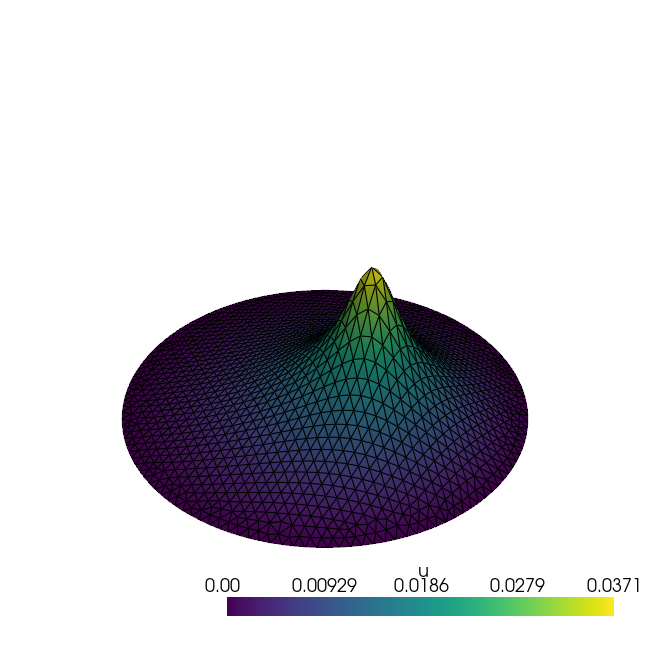

In [12]:
from dolfinx.plot import vtk_mesh
import pyvista

# pyvista.start_xvfb()   # only needed if I am using containers with fenicsx installed 

# Extract topology from mesh and create pyvista mesh
topology, cell_types, x = vtk_mesh(V)
grid = pyvista.UnstructuredGrid(topology, cell_types, x)

# Set deflection values and add it to plotter
grid.point_data["u"] = uh.x.array.real    # associate a scalar field to the grid nodes
warped = grid.warp_by_scalar("u", factor=25)  # wrap_by_scalar will move the points towards the 
# normal direction to the surface based on the scalar value of uh (factor=25 will amplify this effect 25 times!)


# grid.set_active_scalars("u") #(if I had done this instead I would have had a "flat" plot)


# now I plot 
plotter = pyvista.Plotter(window_size=(650,650))
plotter.add_mesh(warped, show_edges=True, show_scalar_bar=True, scalars="u")
# plotter.add_mesh(grid, show_edges=True, show_scalar_bar=True, scalars="u")
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    plotter.screenshot("deflection.png")

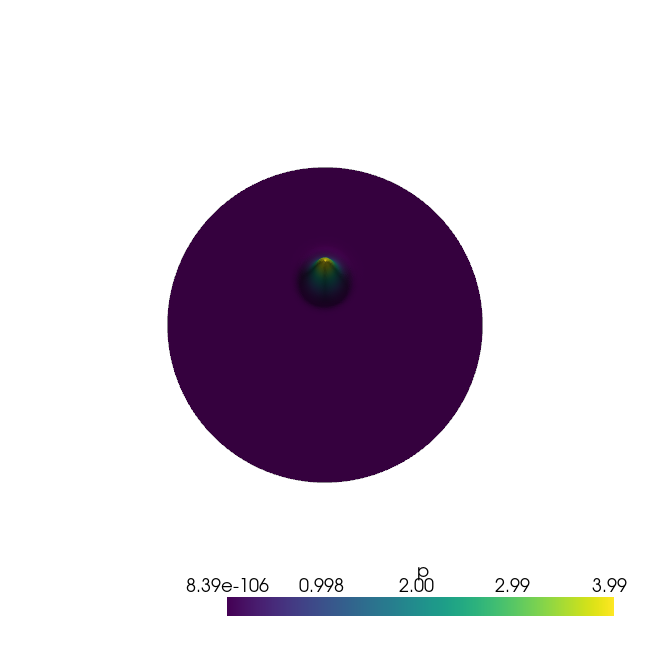

In [13]:
load_plotter = pyvista.Plotter(window_size=(650,650))
p_grid = pyvista.UnstructuredGrid(*vtk_mesh(Q))
p_grid.point_data["p"] = pressure.x.array.real
warped_p = p_grid.warp_by_scalar("p", factor=0.5)
warped_p.set_active_scalars("p")
load_plotter.add_mesh(warped_p, show_scalar_bar=True)
load_plotter.view_xy()
if not pyvista.OFF_SCREEN:
    load_plotter.show()
else:
    load_plotter.screenshot("load.png")

Now I want to compare the deflection D (u) and the pressure p in another way.
That is, along a line.
I decide to choose the line of the domain at x=0 (which coincides with the y-axis).

In [14]:
tol = 0.001  # Avoid hitting the outside of the domain
y = np.linspace(-1 + tol, 1 - tol, 101) #ricordo che il dominio è una circonferenza centrata in (0,0) di raggio unitario
points = np.zeros((3, 101))
points[1] = y
u_values = []
p_values = []

In [15]:
from dolfinx import geometry
bb_tree = geometry.bb_tree(domain, domain.topology.dim)

In [16]:
cells = []
points_on_proc = []
# Find cells whose bounding-box collide with the the points
cell_candidates = geometry.compute_collisions_points(bb_tree, points.T)
# Choose one of the cells that contains the point
colliding_cells = geometry.compute_colliding_cells(domain, cell_candidates, points.T)
for i, point in enumerate(points.T):
    if len(colliding_cells.links(i)) > 0:
        points_on_proc.append(point)
        cells.append(colliding_cells.links(i)[0])

In [17]:
points_on_proc = np.array(points_on_proc, dtype=np.float64)
u_values = uh.eval(points_on_proc, cells)
p_values = pressure.eval(points_on_proc, cells)

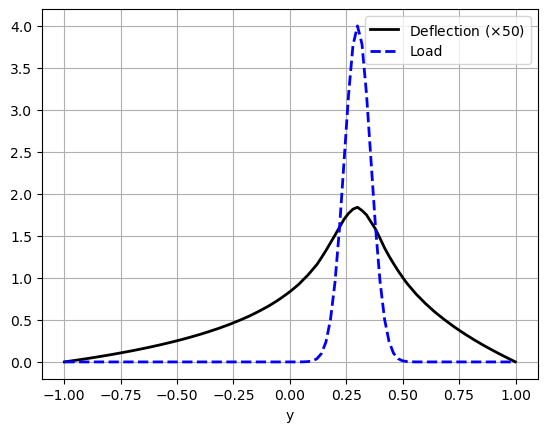

In [18]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(points_on_proc[:, 1], 50 * u_values, "k", linewidth=2, label="Deflection ($\\times 50$)")
plt.plot(points_on_proc[:, 1], p_values, "b--", linewidth=2, label="Load")
plt.grid(True)
plt.xlabel("y")
plt.legend()
# If run in parallel as a python file, we save a plot per processor
plt.savefig(f"membrane_rank{MPI.COMM_WORLD.rank:d}.png")